In [2]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPool2D, Flatten, Dense
import tensorflow as tf
import cv2
import matplotlib.pyplot as plt
import os 
import imghdr
import  numpy as np



#### 1 Cleaning the images 


In [3]:
# Limiting tensorflow on GPU usage 
gpus = tf.config.experimental.list_physical_devices('GPU')
for i in gpus:
    tf.config.experimental.set_memory_growth(i, True)

In [4]:
list_ext = ['jpeg','bmp','png','jpg']

In [5]:
img_folder = 'images'
dir_img = os.listdir(img_folder)

### Checking for right extentions 

In [6]:
for mood_class in dir_img:
    for img in os.listdir(os.path.join(img_folder,mood_class)):
        path = os.path.join(img_folder,mood_class,img)
        try:
            open = cv2.imread(path)
            ex = imghdr.what(path)
            if not ex in list_ext:
                os.remove(path)
                print(f"One image was removed : {img}")
        except:
            os.remove(path)
            print(f"Issue with data {img}")

In [7]:
one = cv2.imread(os.path.join(img_folder,'happy','15_0511_pura_vida-0045-900x600.jpg'))


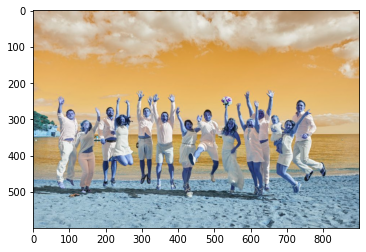

In [8]:
plt.imshow(one)

## load data


#### albeling the data


In [9]:
data  = tf.keras.utils.image_dataset_from_directory(img_folder,batch_size= 16)


Found 270 files belonging to 2 classes.


##### getting the data


In [10]:
data_itr = data.as_numpy_iterator()
batch = data_itr.next()


##### plotting images to see lables


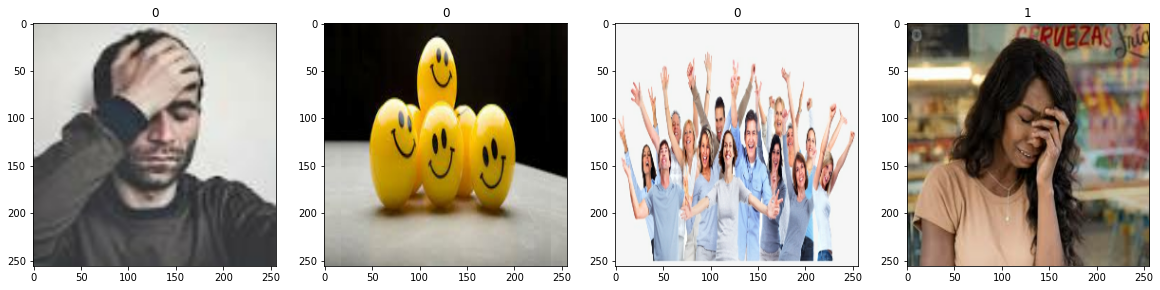

In [11]:
# 1 -> sad 2-> happy
fig, ax = plt.subplots(ncols=4, figsize = (20,20))
for idx , img  in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])

### Preprocessing

In [12]:
(batch[0] / 255).max()

1.0

##### Scaling images 


In [13]:
data = data.map(lambda x,y: (x/255,y))

In [14]:
scaled_iterator = data.as_numpy_iterator()
batch = scaled_iterator.next()
batch[0].max()

1.0

##### Splitting the data

In [15]:
len(data)

17

In [16]:
train_size = int(len(data)*.7)
val_size = int(len(data)*.2)+1
test_size = int(len(data)*.1)+1

##### Actual data splitting 

In [17]:
train = data.take(train_size)
val = data.skip(train_size).take(val_size)
test = data.skip(train_size+val_size).take(test_size)


### Deep learning

##### Build a deep learing model

In [18]:
# setting a random seed 
tf.random.set_seed(42)


#### Model creating and compiling 

In [19]:
model_1 =  Sequential([
    Conv2D(16,(3,3),1, activation= "relu", input_shape = (256,256,3)),
    MaxPool2D(),

    Conv2D(32,(3,3),1, activation="relu"),
    MaxPool2D(),
    
    Conv2D(16,(3,3),1, activation="relu"),
    MaxPool2D(),

    Flatten(),

    Dense(256,activation = 'relu'),
    Dense(1,activation="sigmoid")
])


model_1.compile(
    loss = tf.keras.losses.BinaryCrossentropy(),
    optimizer= tf.keras.optimizers.Adam(),
    metrics= ["accuracy"]
)

model_1.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 127, 127, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 62, 62, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 60, 60, 16)        4624      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 30, 30, 16)       0

In [25]:
from tensorflow.keras.utils import plot_model

In [26]:
plot_model(model_1)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.


In [27]:
logs = "logs"

tensor_callback = tf.keras.callbacks.TensorBoard(log_dir=logs)

hist = model_1.fit(train,epochs=20,validation_data=val ,callbacks=[tensor_callback])



Epoch 1/20
11/11 [==============================] - 15s 972ms/step - loss: 0.7781 - accuracy: 0.4773 - val_loss: 0.6839 - val_accuracy: 0.5000
Epoch 2/20
11/11 [==============================] - 12s 962ms/step - loss: 0.6457 - accuracy: 0.6307 - val_loss: 0.6027 - val_accuracy: 0.6406
Epoch 3/20
11/11 [==============================] - 11s 878ms/step - loss: 0.4533 - accuracy: 0.8125 - val_loss: 0.4862 - val_accuracy: 0.7500
Epoch 4/20
11/11 [==============================] - 12s 913ms/step - loss: 0.5498 - accuracy: 0.7557 - val_loss: 0.3918 - val_accuracy: 0.7969
Epoch 5/20
11/11 [==============================] - 11s 894ms/step - loss: 0.3687 - accuracy: 0.8466 - val_loss: 0.3287 - val_accuracy: 0.7969
Epoch 6/20
11/11 [==============================] - 11s 863ms/step - loss: 0.2283 - accuracy: 0.9432 - val_loss: 0.1521 - val_accuracy: 0.9688
Epoch 7/20
11/11 [==============================] - 11s 895ms/step - loss: 0.2218 - accuracy: 0.9375 - val_loss: 0.1183 - val_accuracy: 1.0000

#### Evaluating 


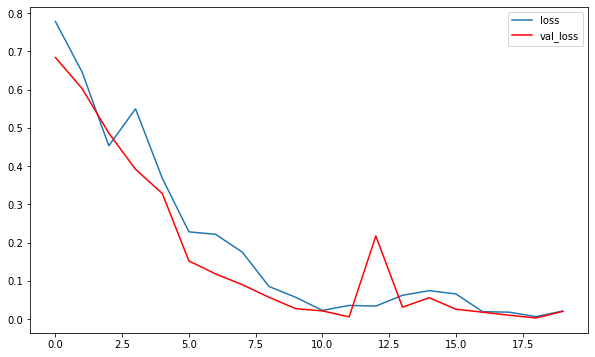

In [40]:
plt.figure(figsize = (10,6))
plt.plot(hist.history['loss'], label= "loss")
plt.plot(hist.history['val_loss'], c = 'red', label = 'val_loss')
plt.legend();

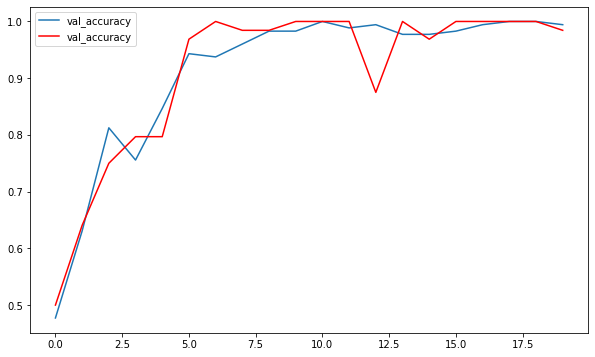

In [42]:
plt.figure(figsize = (10,6))
plt.plot(hist.history['accuracy'], label= "val_accuracy")
plt.plot(hist.history['val_accuracy'], c = 'red', label = 'val_accuracy')
plt.legend();

### Testing 

##### importing testing metrics

In [48]:
from tensorflow.keras.metrics import Precision , Recall , BinaryAccuracy

In [49]:
pre = Precision()
rec = Recall()
acc = BinaryAccuracy()

##### predicting results based on test set 

In [54]:
for i in test.as_numpy_iterator():
    X,y =i
    yhat = model_1.predict(X)
    pre.update_state(y,yhat)
    rec.update_state(y,yhat)
    acc.update_state(y,yhat)

#### printing result values

In [55]:
print(f"Precision: {pre.result()},Recall: {rec.result()}, Accuracy: {acc.result()}")

Precision: 1.0,Recall: 1.0, Accuracy: 1.0
